In [3]:
!pip install -U pennylane networkx scipy numpy matplotlib pandas


In [4]:
# ==========================================
#PIPELINE: MaxCut Benchmark + Transformer J->J' + QAOA parameter transfer
# N <= 20, professional logging/saving/plots
# ==========================================

import os, json, time, itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from numpy.linalg import norm, eigh
from scipy.optimize import minimize
from scipy.stats import spearmanr

import pennylane as qml

# -----------------------------
# 0) CONFIG
# -----------------------------
SEED = 42
rng = np.random.default_rng(SEED)

N = 16                 # <= 20
EDGE_P = 0.35
P_QAOA = 3              # depth
ITERS = 160             # optimizer steps per run
LR = 0.12               # Adam lr
RESTARTS_BASELINE = 10
RESTARTS_SOURCE = 10
FINETUNE_ITERS = 140
FINETUNE_LR = 0.08
FINETUNE_NOISE = 0.12   # small noise around transferred params

# Transformer search budget (keep it moderate to avoid huge cost)
MAXITER_LBFGS = 160
N_RANDOM_PERMS = 10
K_EIG = 6
TRI_SAMPLES = 4000

# Suite size (to make "gap" convincing without crazy cost)
SEEDS_PER_FAMILY = 5    # e.g. 5 => total 15 instances (3 families)
WEIGHT_RANGE = (0.2, 1.8)

SAVE_DIR = "./final_maxcut_transformer_benchmark"
os.makedirs(SAVE_DIR, exist_ok=True)

np.set_printoptions(precision=4, suppress=True)

FAMILIES = [
    {"family": "ER_unweighted", "kind": "er", "weighted": False},
    {"family": "ER_weighted",   "kind": "er", "weighted": True},
    {"family": "RR_3regular",   "kind": "rr", "weighted": False, "deg": 3},
]

print("✅ Config loaded")
print("N=", N, "| total instances =", len(FAMILIES)*SEEDS_PER_FAMILY)
print("P_QAOA=", P_QAOA, "| restarts baseline/source =", RESTARTS_BASELINE, "/", RESTARTS_SOURCE)










✅ Config loaded
N= 16 | total instances = 15
P_QAOA= 3 | restarts baseline/source = 10 / 10


# 1) CORE: Ising + MaxCut helpers

In [5]:
def ensure_sym_zero_diag(J: np.ndarray) -> np.ndarray:
    J = np.asarray(J, dtype=float)
    J = 0.5*(J + J.T)
    np.fill_diagonal(J, 0.0)
    return J

def ising_energy_classical(J: np.ndarray, s: np.ndarray) -> float:
    # E(s) = -1/2 s^T J s
    J = ensure_sym_zero_diag(J)
    s = np.asarray(s, dtype=float)
    return float(-0.5 * s @ (J @ s))

def edges_from_graph(G: nx.Graph):
    edges = []
    for u, v, dat in G.edges(data=True):
        w = float(dat.get("weight", 1.0))
        i, j = int(u), int(v)
        if i > j:
            i, j = j, i
        edges.append((i, j, w))
    edges.sort()
    return edges

def cut_value_from_spins(G: nx.Graph, s: np.ndarray) -> float:
    s = np.asarray(s, dtype=int)
    edges = edges_from_graph(G)
    cut = 0.0
    for i, j, w in edges:
        if s[i] != s[j]:
            cut += w
    return float(cut)

def brute_force_maxcut(G: nx.Graph):
    n = G.number_of_nodes()
    assert n <= 20
    edges = edges_from_graph(G)

    best_cut = -1e18
    best_s = None
    for mask in range(1 << n):
        s = np.array([1 if (mask >> i) & 1 else -1 for i in range(n)], dtype=int)
        cut = 0.0
        for i, j, w in edges:
            if s[i] != s[j]:
                cut += w
        if cut > best_cut:
            best_cut = cut
            best_s = s.copy()
    return {"best_cut": float(best_cut), "best_spins": best_s}





# 2) Benchmark generators


In [6]:


def generate_connected_er(n: int, p: float, seed: int):
    G = nx.erdos_renyi_graph(n=n, p=p, seed=seed)
    if not nx.is_connected(G):
        comps = list(nx.connected_components(G))
        for k in range(len(comps)-1):
            u = next(iter(comps[k]))
            v = next(iter(comps[k+1]))
            G.add_edge(u, v)
    return G

def generate_connected_random_regular(n: int, d: int, seed: int):
    if (n*d) % 2 != 0:
        d += 1
    d = min(d, n-1)
    G = nx.random_regular_graph(d=d, n=n, seed=seed)
    if not nx.is_connected(G):
        comps = list(nx.connected_components(G))
        for k in range(len(comps)-1):
            u = next(iter(comps[k]))
            v = next(iter(comps[k+1]))
            G.add_edge(u, v)
    return G

def apply_edge_weights(G: nx.Graph, seed: int, w_range=WEIGHT_RANGE):
    rr = np.random.default_rng(seed)
    for u, v in G.edges():
        G[u][v]["weight"] = float(rr.uniform(*w_range))

def build_instance(family_spec: dict, seed: int):
    if family_spec["kind"] == "er":
        G = generate_connected_er(N, EDGE_P, seed)
    elif family_spec["kind"] == "rr":
        G = generate_connected_random_regular(N, family_spec.get("deg", 3), seed)
    else:
        raise ValueError("unknown kind")

    if family_spec.get("weighted", False):
        apply_edge_weights(G, seed=seed+999)

    # Ensure nodes are 0..N-1
    G = nx.relabel_nodes(G, {u:i for i,u in enumerate(sorted(G.nodes()))})
    edges = edges_from_graph(G)

    return {"G": G, "edges": edges, "family": family_spec["family"], "seed": seed}

print("✅ Core + generators ready")

✅ Core + generators ready



# 3) Paper-family: J'_{ij} = P_i + P_j and analytic solver


In [7]:

def build_Jprime_from_P(P: np.ndarray) -> np.ndarray:
    P = np.asarray(P, dtype=float)
    Jp = P[:, None] + P[None, :]
    np.fill_diagonal(Jp, 0.0)
    return Jp

def analytic_ground_state_from_P(P: np.ndarray):
    """
    Theorem-consistent: sort P desc, choose best threshold M.
    Returns s* and E* computed with matrix energy.
    """
    P = np.asarray(P, dtype=float)
    n = P.size

    idx = np.argsort(-P)
    P_sorted = P[idx]
    A = np.cumsum(P_sorted)
    A_N = float(A[-1]) if n else 0.0

    best_F = -np.inf
    best_M = 0
    for M in range(n+1):
        S = 2*M - n
        A_M = float(A[M-1]) if M > 0 else 0.0
        W = 2*A_M - A_N
        F = S * W
        if F > best_F:
            best_F, best_M = F, M

    s_sorted = np.empty(n, dtype=int)
    s_sorted[:best_M] = +1
    s_sorted[best_M:] = -1

    s = np.empty(n, dtype=int)
    s[idx] = s_sorted

    E = ising_energy_classical(build_Jprime_from_P(P), s)
    return s, float(E)


# 4) Transformer: fit J -> J'(P) using proxies (lightweight but meaningful)


In [8]:

def candidate_permutations(J: np.ndarray, n_random: int, seed: int):
    rr = np.random.default_rng(seed)
    J = ensure_sym_zero_diag(J)
    n = J.shape[0]
    perms = []

    rm = J.mean(axis=1)
    perms.append(np.argsort(-rm))
    perms.append(np.argsort(rm))

    strength = np.sum(np.abs(J), axis=1)
    perms.append(np.argsort(-strength))

    try:
        w, v = eigh(J)
        vtop = v[:, np.argmax(w)]
        perms.append(np.argsort(-vtop))
    except Exception:
        pass

    for _ in range(n_random):
        p = np.arange(n)
        rr.shuffle(p)
        perms.append(p)

    uniq, seen = [], set()
    for p in perms:
        t = tuple(p.tolist())
        if t not in seen:
            uniq.append(np.array(p, dtype=int))
            seen.add(t)
    return uniq

def behavior_metrics(J: np.ndarray, Jp: np.ndarray, k: int, tri_samples: int, seed: int):
    rr = np.random.default_rng(seed)
    J = ensure_sym_zero_diag(J)
    Jp = ensure_sym_zero_diag(Jp)
    n = J.shape[0]

    recon = float(norm(J - Jp, 'fro') / (norm(J, 'fro') + 1e-12))

    rmJ, rmP = J.mean(axis=1), Jp.mean(axis=1)
    rowcorr = 0.0
    if np.std(rmJ) > 1e-12 and np.std(rmP) > 1e-12:
        rowcorr = float(np.corrcoef(rmJ, rmP)[0, 1])
        if np.isnan(rowcorr): rowcorr = 0.0

    eig_overlap = 0.0
    try:
        wJ, vJ = eigh(J)
        wP, vP = eigh(Jp)
        kk = min(k, n-1)
        idxJ = np.argsort(wJ)[-kk:][::-1]
        idxP = np.argsort(wP)[-kk:][::-1]
        ov = 0.0
        for a, b in zip(idxJ, idxP):
            ov += abs(float(vJ[:, a] @ vP[:, b]))
        eig_overlap = float(ov / max(1, kk))
    except Exception:
        eig_overlap = 0.0

    # triangle frustration correlation (sampled)
    def local_frust(A):
        lf = np.zeros(n); cnt = np.zeros(n)
        for _ in range(tri_samples):
            i, j, k = rr.integers(0, n, size=3)
            if len({i, j, k}) < 3:
                continue
            prod = A[i, j]*A[j, k]*A[k, i]
            cnt[i] += 1; cnt[j] += 1; cnt[k] += 1
            if prod < 0:
                lf[i] += 1; lf[j] += 1; lf[k] += 1
        lf = np.divide(lf, cnt, out=np.zeros_like(lf), where=cnt > 0)
        return lf

    lfJ = local_frust(J)
    lfP = local_frust(Jp)
    frust_corr = 0.0
    if np.std(lfJ) > 1e-12 and np.std(lfP) > 1e-12:
        frust_corr = float(np.corrcoef(lfJ, lfP)[0, 1])
        if np.isnan(frust_corr): frust_corr = 0.0

    behavior = float(0.45*max(0, rowcorr) + 0.35*max(0, eig_overlap) + 0.20*max(0, frust_corr))
    return {
        "recon": recon,
        "rowcorr": rowcorr,
        "eig_overlap": eig_overlap,
        "frust_corr": frust_corr,
        "behavior": behavior
    }

def build_P_powerlaw(a: float, d: float, b: float, perm: np.ndarray):
    n = len(perm)
    ranks = np.arange(1, n+1, dtype=float)
    P_sorted = a * (ranks ** d) + b
    P = np.empty(n, dtype=float)
    for pos, node in enumerate(perm):
        P[node] = P_sorted[pos]
    return P

def transformer_fit_powerlaw(J: np.ndarray,
                             seed: int,
                             n_random_perms: int = N_RANDOM_PERMS,
                             maxiter: int = MAXITER_LBFGS,
                             k_eig: int = K_EIG,
                             tri_samples: int = TRI_SAMPLES,
                             alpha: float = 1.0,
                             beta: float = 6.0):
    """
    Minimize: alpha*recon - beta*behavior
    """
    J = ensure_sym_zero_diag(J)
    n = J.shape[0]

    perms = candidate_permutations(J, n_random=n_random_perms, seed=seed)

    base = J.mean(axis=1)
    a0 = (base.max() - base.min()) / max(1.0, n**0.8)
    b0 = float(base.mean())
    inits = [
        [ a0, 1.5, b0],
        [ 0.5*a0, 1.5, b0],
        [ 1.5*a0, 1.5, b0],
        [-a0, 1.5, b0],
    ]

    best = None
    best_obj = 1e300

    for perm in perms:
        for init in inits:
            def loss(x):
                a, d, b = float(x[0]), float(x[1]), float(x[2])
                if d <= 0:
                    return 1e6
                P = build_P_powerlaw(a, d, b, perm)
                Jp = build_Jprime_from_P(P)
                m = behavior_metrics(J, Jp, k=k_eig, tri_samples=tri_samples, seed=seed)
                return float(alpha*m["recon"] - beta*m["behavior"] + 1e-8*(a*a + d*d + b*b))

            res = minimize(
                loss,
                x0=np.array(init, float),
                method="L-BFGS-B",
                bounds=[(-10,10), (0.01,6.0), (-10,10)],
                options={"maxiter": maxiter}
            )

            a_opt, d_opt, b_opt = map(float, res.x)
            P_opt = build_P_powerlaw(a_opt, d_opt, b_opt, perm)
            Jp_opt = build_Jprime_from_P(P_opt)
            m = behavior_metrics(J, Jp_opt, k=k_eig, tri_samples=tri_samples, seed=seed)

            obj = float(alpha*m["recon"] - beta*m["behavior"])
            if obj < best_obj:
                best_obj = obj
                best = {
                    "a": a_opt, "d": d_opt, "b": b_opt,
                    "perm": perm.copy(),
                    "P": P_opt,
                    "Jp": Jp_opt,
                    "metrics": m,
                    "obj": best_obj
                }
    return best




# 5) QAOA (professional + stable): build Hamiltonian ONCE, expval(H) ONLY


In [9]:

def build_cut_hamiltonian(edges_ijw, n: int):
    """
    Cut operator:
      C = Σ w/2 (1 - ZiZj) = const + Σ (-w/2) ZiZj
    We'll return (const, Hzz) where Hzz = Σ (-w/2) ZiZj
    """
    const = 0.5 * sum(w for _, _, w in edges_ijw)
    coeffs, ops = [], []
    for i, j, w in edges_ijw:
        coeffs.append(-0.5 * float(w))
        ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    Hzz = qml.Hamiltonian(coeffs, ops) if coeffs else qml.Hamiltonian([0.0], [qml.Identity(0)])
    return float(const), Hzz

def build_dense_energy_hamiltonian(J_dense: np.ndarray):
    """
    Classical energy: E(s) = -1/2 s^T J s  (diag 0, symmetric)
    Quantum expectation analog:
      E(θ) = - Σ_{i<j} J_ij <ZiZj>
    So Hamiltonian H = Σ_{i<j} (-J_ij) ZiZj
    """
    J_dense = ensure_sym_zero_diag(J_dense)
    n = J_dense.shape[0]
    coeffs, ops = [], []
    for i in range(n):
        for j in range(i+1, n):
            Jij = float(J_dense[i, j])
            if abs(Jij) < 1e-12:
                continue
            coeffs.append(-Jij)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    H = qml.Hamiltonian(coeffs, ops) if coeffs else qml.Hamiltonian([0.0], [qml.Identity(0)])
    return H

def qaoa_layer_cost_from_pairs(gamma, pairs):
    # pairs: list[(i,j,phi)] where we implement IsingZZ(phi) as exp(-i phi/2 Z⊗Z)
    # Here we want exp(-i gamma * c_ij Z_i Z_j) => set IsingZZ(phi=2*gamma*c_ij)
    for i, j, cij in pairs:
        qml.IsingZZ(2.0 * gamma * cij, wires=[i, j])

def qaoa_mixer_layer(beta, n):
    for i in range(n):
        qml.RX(2.0 * beta, wires=i)

def make_qnode_cut(edges_ijw, n, p):
    const, Hzz = build_cut_hamiltonian(edges_ijw, n)
    dev = qml.device("default.qubit", wires=n)

    # Build commuting ZZ pairs for cost unitary:
    # cost unitary implements exp(-i gamma * Σ (-w/2) ZiZj) => c_ij = (-w/2)
    pairs = [(i, j, (-0.5*float(w))) for i, j, w in edges_ijw]

    @qml.qnode(dev)
    def cut_qnode(params):
        gammas = params[:p]
        betas  = params[p:]
        for i in range(n):
            qml.Hadamard(wires=i)
        for layer in range(p):
            qaoa_layer_cost_from_pairs(gammas[layer], pairs)
            qaoa_mixer_layer(betas[layer], n)
        return qml.expval(Hzz)

    def cut_expectation(params):
        return float(const + cut_qnode(params))

    def loss(params):
        return -cut_expectation(params)  # maximize cut
    return cut_expectation, loss, cut_qnode

def make_qnode_dense_energy(J_dense, n, p):
    H = build_dense_energy_hamiltonian(J_dense)
    dev = qml.device("default.qubit", wires=n)

    # pairs for unitary: H = Σ (-Jij) ZiZj => c_ij = (-Jij)
    pairs = []
    J_dense = ensure_sym_zero_diag(J_dense)
    for i in range(n):
        for j in range(i+1, n):
            Jij = float(J_dense[i, j])
            if abs(Jij) < 1e-12:
                continue
            pairs.append((i, j, (-Jij)))

    @qml.qnode(dev)
    def energy_qnode(params):
        gammas = params[:p]
        betas  = params[p:]
        for i in range(n):
            qml.Hadamard(wires=i)
        for layer in range(p):
            qaoa_layer_cost_from_pairs(gammas[layer], pairs)
            qaoa_mixer_layer(betas[layer], n)
        return qml.expval(H)

    def energy_expectation(params):
        return float(energy_qnode(params))

    def loss(params):
        return energy_expectation(params)  # minimize energy
    return energy_expectation, loss, energy_qnode

def optimize_adam(loss_fn, p, iters, lr, seed, init=None, log_every=0):
    rr = np.random.default_rng(seed)
    params = rr.uniform(0, 2*np.pi, size=2*p) if init is None else np.array(init, float).copy()
    opt = qml.AdamOptimizer(stepsize=lr)

    best = (float("inf"), params.copy())
    hist = []
    for t in range(1, iters+1):
        params = opt.step(lambda x: loss_fn(x), params)
        val = float(loss_fn(params))
        hist.append(val)
        if val < best[0]:
            best = (val, params.copy())
        if log_every and (t % log_every == 0):
            print(f"    iter {t:4d} loss={val:.6f} best={best[0]:.6f}")
    return {"best_loss": best[0], "best_params": best[1], "hist": np.array(hist, float)}

def multi_start_opt(loss_fn, objective_eval_fn, p, iters, lr, restarts, seed0):
    runs = []
    for r in range(restarts):
        seed = seed0 + 1000*r
        res = optimize_adam(loss_fn, p, iters, lr, seed=seed, init=None)
        theta = res["best_params"]
        val = float(objective_eval_fn(theta))
        runs.append({"theta": theta, "obj": val, "loss": float(res["best_loss"])})
    return runs





# 6) Stage-B correlation (cheap sanity)

In [10]:
def stageB_sanity(E_Jp_fn, Cut_J_fn, p, n_samples=20, seed=0):
    rr = np.random.default_rng(seed)
    thetas = rr.uniform(0, 2*np.pi, size=(n_samples, 2*p))
    Es = np.array([E_Jp_fn(th) for th in thetas], float)
    Cs = np.array([Cut_J_fn(th) for th in thetas], float)
    # We expect lower energy on J' might correlate with better cut on J (not guaranteed)
    rho, pval = spearmanr(-Es, Cs)  # compare (-E) vs cut
    return float(rho if not np.isnan(rho) else 0.0), float(pval if not np.isnan(pval) else 1.0)



# 7) RUN SUITE

In [11]:

all_results = []
t0 = time.time()

for fam in FAMILIES:
    for k in range(SEEDS_PER_FAMILY):
        seed = SEED + 100*fam.get("deg", 0) + k + (0 if fam["family"]=="ER_unweighted" else 1000 if fam["family"]=="ER_weighted" else 2000)
        inst = build_instance(fam, seed)

        G = inst["G"]
        edges = inst["edges"]
        n = G.number_of_nodes()

        # Build J from the same MaxCut convention (J_ij = -w_ij on edges)
        J = np.zeros((n, n), float)
        for i, j, w in edges:
            J[i, j] = -w
            J[j, i] = -w
        J = ensure_sym_zero_diag(J)

        # --- Transformer: J -> P,J' ---
        tf = transformer_fit_powerlaw(J, seed=seed)
        P = tf["P"]
        Jp = tf["Jp"]
        metrics = tf["metrics"]

        # analytic on J' (diagnostic only)
        sJp, EJp_analytic = analytic_ground_state_from_P(P)
        cut_from_sJp = cut_value_from_spins(G, sJp)

        # QNodes
        cut_J, loss_cutJ, _ = make_qnode_cut(edges, n, P_QAOA)
        E_Jp,  loss_EJp,  _ = make_qnode_dense_energy(Jp, n, P_QAOA)

        # Stage-B correlation
        rho_s, p_s = stageB_sanity(E_Jp, cut_J, P_QAOA, n_samples=20, seed=seed+777)

        # --- Baseline: multi-start on J (maximize cut => minimize -cut) ---
        baseline_runs = multi_start_opt(
            loss_fn=loss_cutJ,
            objective_eval_fn=cut_J,
            p=P_QAOA, iters=ITERS, lr=LR, restarts=RESTARTS_BASELINE,
            seed0=seed+10
        )
        baseline_best = max(baseline_runs, key=lambda x: x["obj"])
        theta_base = baseline_best["theta"]
        cut_base = float(baseline_best["obj"])

        # --- Source: multi-start on J' (minimize energy) ---
        source_runs = multi_start_opt(
            loss_fn=loss_EJp,
            objective_eval_fn=E_Jp,     # lower is better
            p=P_QAOA, iters=ITERS, lr=LR, restarts=RESTARTS_SOURCE,
            seed0=seed+20
        )
        source_best = min(source_runs, key=lambda x: x["obj"])  # energy minimal
        theta_star = source_best["theta"]
        EJp_best = float(source_best["obj"])

        # transfer-only evaluation on target cut
        cut_transfer = float(cut_J(theta_star))

        # warm-finetune on J starting near theta_star
        rr = np.random.default_rng(seed+9999)
        warm_inits = [theta_star] + [theta_star + rr.normal(0, FINETUNE_NOISE, size=2*P_QAOA) for _ in range(3)]
        warm_best_cut = -1e18
        warm_best_theta = None
        warm_hist_best = None

        for idx_init, init in enumerate(warm_inits):
            res = optimize_adam(loss_cutJ, P_QAOA, FINETUNE_ITERS, FINETUNE_LR, seed=seed+3000+idx_init, init=init)
            th = res["best_params"]
            c = float(cut_J(th))
            if c > warm_best_cut:
                warm_best_cut = c
                warm_best_theta = th
                warm_hist_best = res["hist"]

        # brute force optimum for evaluation (N<=20)
        bf = brute_force_maxcut(G)
        cut_opt = float(bf["best_cut"])

        out = {
            "family": inst["family"],
            "seed": int(inst["seed"]),
            "n": int(n),
            "m": int(G.number_of_edges()),
            "weighted": bool(fam.get("weighted", False)),

            "transformer": {
                "a": float(tf["a"]), "d": float(tf["d"]), "b": float(tf["b"]),
                "metrics": {k: float(v) for k, v in metrics.items()},
            },
            "diagnostic": {
                "EJp_analytic": float(EJp_analytic),
                "cut_from_sJp_on_G": float(cut_from_sJp),
                "stageB_spearman_rho": float(rho_s),
                "stageB_pvalue": float(p_s),
            },

            "qaoa": {
                "baseline_best_cut": float(cut_base),
                "transfer_only_cut": float(cut_transfer),
                "warm_finetune_best_cut": float(warm_best_cut),
                "source_best_energy_Jp": float(EJp_best),

                "theta_baseline": theta_base.tolist(),
                "theta_source": theta_star.tolist(),
                "theta_warm": warm_best_theta.tolist(),
            },

            "ground_truth": {
                "cut_opt_bruteforce": float(cut_opt),
                "approx_ratio_baseline": float(cut_base / cut_opt) if cut_opt > 0 else 0.0,
                "approx_ratio_warm": float(warm_best_cut / cut_opt) if cut_opt > 0 else 0.0,
            }
        }

        all_results.append(out)
        print(f"[{out['family']} | seed={out['seed']}] "
              f"opt={cut_opt:.3f} base={cut_base:.3f} tr={cut_transfer:.3f} warm={warm_best_cut:.3f} "
              f"gain(warm-base)={(warm_best_cut-cut_base):+.3f} "
              f"beh={metrics['behavior']:.3f} recon={metrics['recon']:.3f} rho={rho_s:+.2f}")

t1 = time.time()
print("\n✅ Suite done. Time(s) =", round(t1 - t0, 2))

/usr/local/lib/python3.12/dist-packages/pennylane/_grad/grad.py:337: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnums' keyword.
  warnings.warn(


[ER_unweighted | seed=42] opt=35.000 base=27.073 tr=23.015 warm=23.378 gain(warm-base)=-3.694 beh=0.648 recon=0.745 rho=+0.17
[ER_unweighted | seed=43] opt=29.000 base=20.100 tr=19.142 warm=20.875 gain(warm-base)=+0.775 beh=0.616 recon=0.781 rho=+0.04
[ER_unweighted | seed=44] opt=38.000 base=26.679 tr=24.909 warm=24.984 gain(warm-base)=-1.695 beh=0.679 recon=0.752 rho=-0.26
[ER_unweighted | seed=45] opt=31.000 base=19.833 tr=19.734 warm=19.755 gain(warm-base)=-0.077 beh=0.585 recon=0.758 rho=-0.16
[ER_unweighted | seed=46] opt=35.000 base=24.845 tr=20.867 warm=22.872 gain(warm-base)=-1.973 beh=0.572 recon=0.795 rho=-0.25
[ER_weighted | seed=1042] opt=30.680 base=19.864 tr=19.298 warm=19.298 gain(warm-base)=-0.566 beh=0.600 recon=0.961 rho=-0.66
[ER_weighted | seed=1043] opt=30.326 base=19.750 tr=19.630 warm=19.655 gain(warm-base)=-0.095 beh=0.607 recon=0.823 rho=+0.10
[ER_weighted | seed=1044] opt=29.338 base=19.158 tr=17.638 warm=18.330 gain(warm-base)=-0.829 beh=0.664 recon=0.902 rh



# 8) SAVE + SUMMARY TABLES


In [12]:

json_path = os.path.join(SAVE_DIR, "results_all.json")
with open(json_path, "w") as f:
    json.dump(all_results, f, indent=2)
print("Saved:", json_path)

rows = []
for r in all_results:
    m = r["transformer"]["metrics"]
    d = r["diagnostic"]
    q = r["qaoa"]
    gt = r["ground_truth"]
    rows.append({
        "family": r["family"], "seed": r["seed"], "n": r["n"], "m": r["m"], "weighted": r["weighted"],
        "behavior": m["behavior"], "recon": m["recon"], "rowcorr": m["rowcorr"], "eig_overlap": m["eig_overlap"], "frust_corr": m["frust_corr"],
        "stageB_rho": d["stageB_spearman_rho"], "stageB_p": d["stageB_pvalue"],
        "cut_opt": gt["cut_opt_bruteforce"],
        "cut_base": q["baseline_best_cut"],
        "cut_transfer": q["transfer_only_cut"],
        "cut_warm": q["warm_finetune_best_cut"],
        "gain_transfer": q["transfer_only_cut"] - q["baseline_best_cut"],
        "gain_warm": q["warm_finetune_best_cut"] - q["baseline_best_cut"],
        "ratio_base": gt["approx_ratio_baseline"],
        "ratio_warm": gt["approx_ratio_warm"],
        "source_EJp_best": q["source_best_energy_Jp"],
        "cut_from_sJp": d["cut_from_sJp_on_G"]
    })

df = pd.DataFrame(rows)
csv_path = os.path.join(SAVE_DIR, "summary.csv")
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

display(df.head())


Saved: ./final_maxcut_transformer_benchmark/results_all.json
Saved: ./final_maxcut_transformer_benchmark/summary.csv


,family,seed,n,m,weighted,behavior,recon,rowcorr,eig_overlap,frust_corr,...,cut_opt,cut_base,cut_transfer,cut_warm,gain_transfer,gain_warm,ratio_base,ratio_warm,source_EJp_best,cut_from_sJp
0,ER_unweighted,42,16,47,False,0.647613,0.744660,0.942736,0.321345,0.554556,...,35.0,27.072573,23.015254,23.378490,-4.057319,-3.694083,0.773502,0.667957,-0.212746,28.0
1,ER_unweighted,43,16,38,False,0.616080,0.780882,0.935922,0.244288,0.547071,...,29.0,20.100229,19.142234,20.875258,-0.957996,0.775028,0.693111,0.719836,-0.146370,23.0
2,ER_unweighted,44,16,50,False,0.679465,0.751987,0.964146,0.232277,0.821511,...,38.0,26.678614,24.909406,24.983982,-1.769208,-1.694632,0.702069,0.657473,0.096237,28.0
3,ER_unweighted,45,16,39,False,0.585215,0.757536,0.922621,0.185677,0.525243,...,31.0,19.832770,19.734206,19.755466,-0.098564,-0.077304,0.639767,0.637273,0.184944,25.0
4,ER_unweighted,46,16,49,False,0.571735,0.795312,0.927242,0.133344,0.539029,...,35.0,24.845452,20.867297,22.872150,-3.978155,-1.973302,0.709870,0.653490,0.748266,27.0



# 9) PLOTS (clean + research-friendly)


<Figure size 640x480 with 0 Axes>

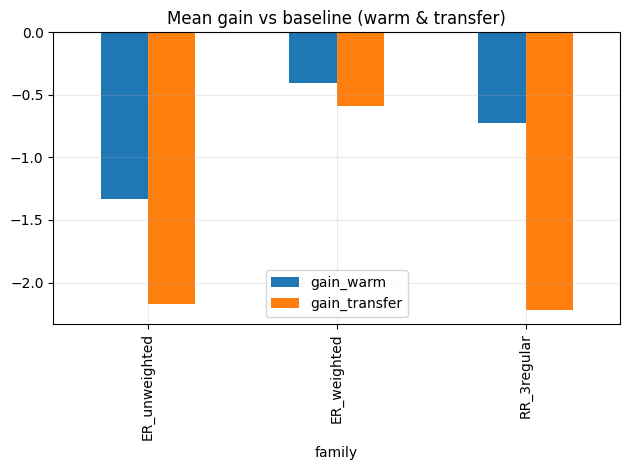

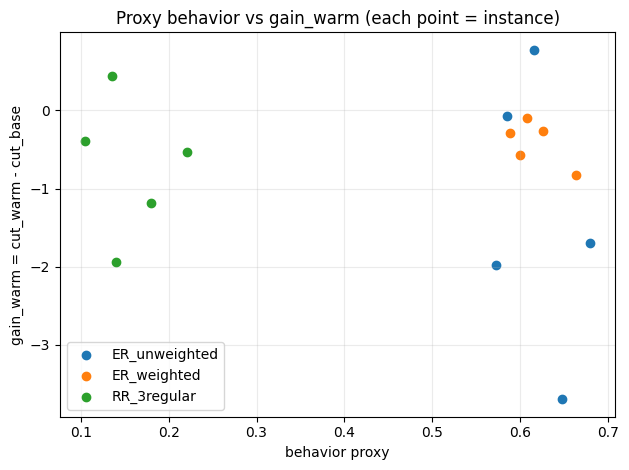

<Figure size 640x480 with 0 Axes>

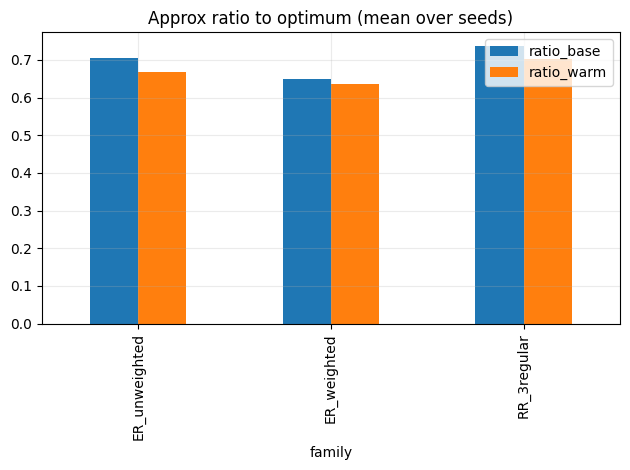

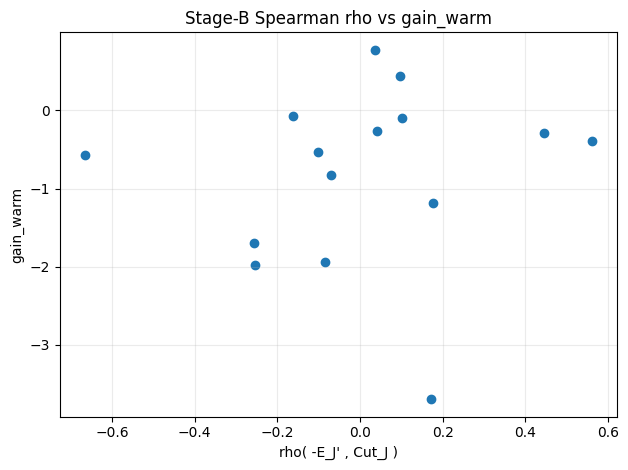


✅ Done. Outputs in: ./final_maxcut_transformer_benchmark


In [13]:
plt.figure()
df.groupby("family")[["gain_warm","gain_transfer"]].mean().plot(kind="bar")
plt.title("Mean gain vs baseline (warm & transfer)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure()
for fam in df["family"].unique():
    sub = df[df["family"] == fam]
    plt.scatter(sub["behavior"], sub["gain_warm"], label=fam)
plt.title("Proxy behavior vs gain_warm (each point = instance)")
plt.xlabel("behavior proxy")
plt.ylabel("gain_warm = cut_warm - cut_base")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
df.groupby("family")[["ratio_base","ratio_warm"]].mean().plot(kind="bar")
plt.title("Approx ratio to optimum (mean over seeds)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# quick sanity: does stageB rho relate to gain?
plt.figure()
plt.scatter(df["stageB_rho"], df["gain_warm"])
plt.title("Stage-B Spearman rho vs gain_warm")
plt.xlabel("rho( -E_J' , Cut_J )")
plt.ylabel("gain_warm")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

print("\n✅ Done. Outputs in:", SAVE_DIR)
